In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from functools import reduce

In [2]:
directory = '../../../Chapters/tables/'

def getBaseProjectData():
    """
    Gets the base data for the project

    Returns:
    A dataframe with user activities
    """
    systemsData = pd.read_csv("../data/uat_raw/systems.csv")
    projectBaseData = pd.read_csv("../data/uat_raw/uat1.csv")
    users = pd.read_csv("../data/uat_raw/users.csv")
    systemsData['Priority'] = systemsData['Priority'] * 10

    temp = pd.merge(systemsData, projectBaseData,on='SubSystemId')
    temp = pd.merge(users, temp, on='UserId')
    return temp.loc[(temp['Project'] == 1) & (temp['Deleted'] == 1)], temp.loc[(temp['Project'] == 2) & (temp['Deleted'] == 1)];

def getNormilisedBySecondCriteria(data, secondFilter):
    temp = data.groupby(['SubSystemId',secondFilter]).agg(Priority=('Priority', 'mean'), Count=('SubSystemId', 'count')).reset_index()

    # get the number of unique entries in the 'ActivityType' column
    num_activity_types = data[secondFilter].nunique()

    # get the first 'Priority' value for each 'SubSystemId'
    first_priority = data.groupby('SubSystemId')['Priority'].first()

    # pivot the table and merge with the first priority values
    pivoted_df = temp.pivot_table(index='SubSystemId', columns=secondFilter, values='Count', fill_value=0)
    pivoted_df = pivoted_df.merge(first_priority, left_index=True, right_index=True).reset_index()

    # get all unique entries in the 'x' column
    unique_values = data[secondFilter].unique()

    for name in unique_values:
        normalised_table_name = f'NormalisedCount_{name}'
        maintenance_table_name = f'MaintenanceFactor_{name}'
        # calculate the normalized count
        pivoted_df[normalised_table_name] = (pivoted_df[name] - pivoted_df[name].min()) / (pivoted_df[name].max() - pivoted_df[name].min())

        # calculate the maintenance factor
        pivoted_df[maintenance_table_name] = pivoted_df[normalised_table_name] * pivoted_df['Priority']

    return pivoted_df

def getNormalisedByTotal(data):
    temp = data.groupby(['SubSystemId']).agg(Priority=('Priority', 'mean'), Count=('SubSystemId', 'count')).reset_index()
    temp['NormalisedCount'] = temp['Count'].apply(lambda x: 
        (x-temp['Count'].min())/(temp['Count'].max()-temp['Count'].min()))

    temp['MaintenanceFactor'] = temp.apply(lambda row: row['NormalisedCount'] * row['Priority'], axis=1)
    return temp

In [3]:
# Get project actvities
projectA, projectB = getBaseProjectData()

# Get project total activities per project
projectA_Normilised = getNormalisedByTotal(projectA)
projectB_Normilised = getNormalisedByTotal(projectB)
projectA_ByActivityType = getNormilisedBySecondCriteria(projectA, 'ActivityType')
projectB_ByActivityType = getNormilisedBySecondCriteria(projectB, 'ActivityType')

In [4]:
def createLatexRows(data, filename, caption):
    latex_rows = ''
    for index, row in data.iterrows():
        latex_rows += '\n {:d} & {:d} & {:d} & {:.4f} & {:.4f} \\\ \\hline'.format(int(row['SubSystemId']), int(row['Priority']), int(row['Count']), row['NormalisedCount'], row['MaintenanceFactor'])

    header = r"""
    \begin{xltabular}{\textwidth}{|X|X|X|X|X|}
        \caption[%s]
        {\textit{%s}}
        \label{tbl:apx_%s} \\
        
        \hline
        \textbf{Subsystem} & \textbf{Priorty}  & \textbf{Actvities} & \textbf{Normalised Actvity} & \textbf{Maintenance Actvity} \\
        \hline
        \endfirsthead

        \multicolumn{5}{c}
        {\tablename\ \thetable{} -- continued from previous page} \\
        \hline
        \textbf{Subsystem} & \textbf{Priorty}  & \textbf{Actvities} & \textbf{Normalised Actvity} & \textbf{Maintenance Actvity} \\ 
        \endhead

        \multicolumn{5}{|r|}{{Continued on next page}} \\ \hline
        \endfoot

        \hline
        \endlastfoot
    """ % (caption, caption, filename) 
    
    table = header + latex_rows.strip() + r"""
    \end{xltabular}
    """

    filepath = directory + filename + '.tex'

    # Write the latex_rows string to the file
    with open(filepath, 'w') as f:
        f.write(table)


createLatexRows(projectA_Normilised, "projectA_Normilised", "Case study A results")
createLatexRows(projectB_Normilised, "projectB_Normilised", "Case study B results")

In [5]:
def createLatexMultiRows(data, filename, caption, unique_tables):
    # create a new list to store the updated names
    updated_names = []
    table_index = '|X|X|'
    table_names = """\\textbf{$S_X$} & \\textbf{Priorty}"""

    # iterate over each unique name
    for name in unique_tables:
        # append the original name
        updated_names.append(name)
        
        # append the first suffix
        updated_names.append(f'NormalisedCount_{name}')
        # append the second suffix
        updated_names.append(f'MaintenanceFactor_{name}')

        table_index = f'{table_index}X|X|X|'
        table_names = f'{table_names} & \\textbf{{{name}}} & \\textbf{{$N_{{{name}}}$}} & \\textbf{{$M_{{{name}}}$}}'

    table_count = len(updated_names) + 2

    header = r"""
    \begin{scriptsize}
        \begin{xltabular}{\linewidth}{%s}
            \caption[%s]
            {\textit{%s}}
            \label{tbl:apx_%s} \\
            
            \hline
            %s \\
            \hline
            \endfirsthead

            \multicolumn{%s}{c}
            {\tablename\ \thetable{} -- continued from previous page} \\
            \hline
            %s \\ 
            \endhead

            \multicolumn{%s}{|r|}{{Continued on next page}} \\ \hline
            \endfoot

            \hline
            \endlastfoot
    """ % (table_index, caption, caption, filename, table_names, table_count,table_names, table_count)

    latex_rows = ''
    for index, row in data.iterrows():
        latex_rows += '\n {:d} & {:d}'.format(int(row['SubSystemId']), int(row['Priority']))

        for temp_name in updated_names:
            latex_rows += ' & {:.6f}'.format(int(row[temp_name]))

        latex_rows += '\\\ \\hline'

    table = r"""
    %s
            %s
        \end{xltabular}
    \end{scriptsize}
    """ % (header, latex_rows.strip())

    filepath = directory + filename + '.tex'

    # Write the latex_rows string to the file
    with open(filepath, 'w') as f:
        f.write(table)

createLatexMultiRows(projectA_ByActivityType, 'projectA_UserNormilised', 'Case study A results', projectA['ActivityType'].unique().tolist()) 
createLatexMultiRows(projectB_ByActivityType, 'projectB_UserNormilised', 'Case study B results', projectB['ActivityType'].unique().tolist()) 

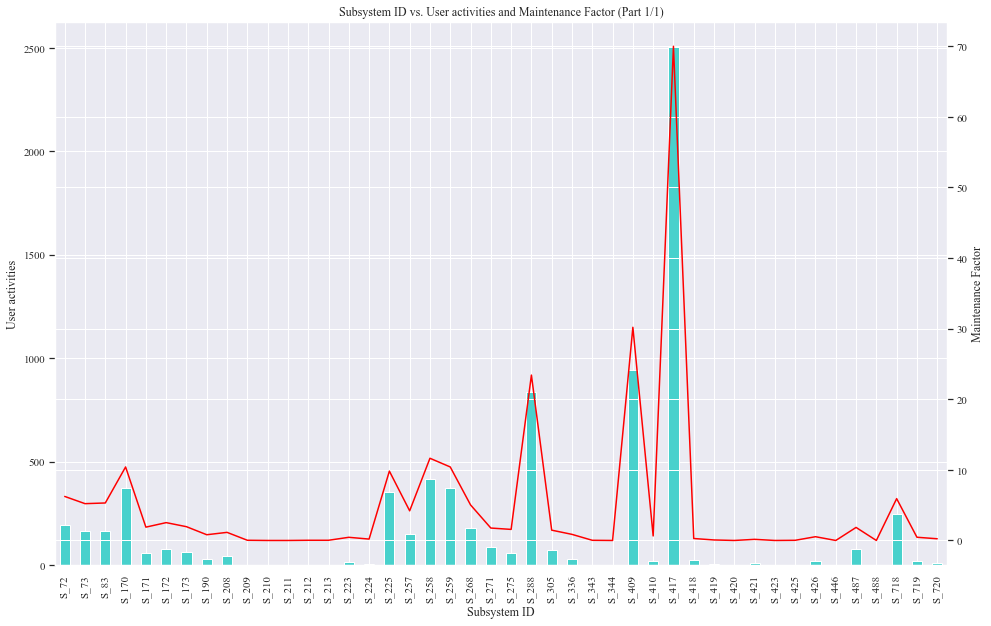

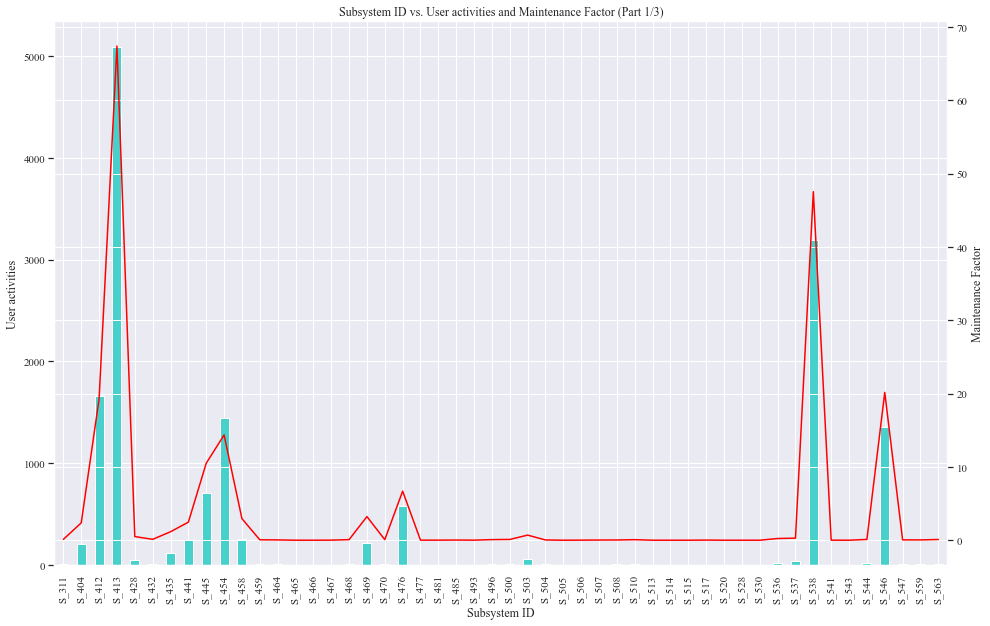

In [6]:
def createFigures(data, case):
    sns.set(style="darkgrid")
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.figsize"] = (16,10)

    # get the unique SubSystemIds
    subsystem_ids = data['SubSystemId'].unique()

    # set the number of subsystems to show per graph
    num_subsystems_per_graph = 50

    # calculate the number of graphs needed
    num_graphs = int(np.ceil(len(subsystem_ids) / num_subsystems_per_graph))

    data['SS_SystemId'] = "S" + '_' + data['SubSystemId'].astype(str)

    # loop through each graph
    for i in range(num_graphs):
        start_index = i * num_subsystems_per_graph
        end_index = min((i+1) * num_subsystems_per_graph, len(subsystem_ids))
        current_ids = subsystem_ids[start_index:end_index]

        # filter the data to show only the current subsystem ids
        current_data = data[data['SubSystemId'].isin(current_ids)]

        # create figure and axis objects with subplots()
        fig, ax = plt.subplots()

        # create a twin axis object that shares the x-axis
        ax2 = ax.twinx()

        # plot the bar chart
        current_data.plot(kind='bar', x='SS_SystemId', y='Count', ax=ax, color='mediumturquoise', legend=False)
        ax.set_ylabel('User activities')

        # plot the line graph on the twin axis
        current_data.plot(kind='line', x='SS_SystemId', y='MaintenanceFactor', ax=ax2, color='red', legend=False)
        ax2.set_ylabel('Maintenance Factor')

        # set the x-axis label and tick label rotation
        ax.set_xlabel('Subsystem ID')
        plt.xticks(rotation='horizontal')

        # add a title to the chart
        plt.title(f'Subsystem ID vs. User activities and Maintenance Factor (Part {i+1}/{num_graphs})')

        # save the current figure
        plt.savefig(f'../../../img/ch3/analysis/case_{case}_subsystems_{i+1}.pdf', format="pdf", bbox_inches="tight")

        # close the figure to free memory
        plt.close(fig)

createFigures(projectA_Normilised, 'A')
createFigures(projectB_Normilised, 'B')

In [ ]:
df = pd.read_csv("../data/uat_raw/systems2.csv")

# Remove rows with null values in 'System' column
df = df.dropna(subset=['System'])

# Add unique SystemId to the dataframe
df['SystemId'] = pd.factorize(df['System'])[0] + 1

# create a dictionary to map subsystem path to subsystem id
subsystem_id_map = {subsys: idx+1 for idx, subsys in enumerate(df['SubSystem'].unique())}

# update subsystem ids that have the same first two parts
for idx, subsys in enumerate(df['SubSystem'].unique()):
    parts = subsys.strip('/').split('/')
    subsys_key = '/'.join(parts[:2])
    if subsys_key in subsystem_id_map and subsystem_id_map[subsys_key] != idx+1:
        subsystem_id_map[subsys] = subsystem_id_map[subsys_key]

# map subsystem path to subsystem id in the dataframe
df['SubsystemUId'] = df['SubSystem'].apply(lambda x: subsystem_id_map[x])